In [1]:
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister, execute, transpile, Aer, IBMQ # circuit creation and execution
from qiskit.providers.aer.noise import NoiseModel # simulate backends
from qiskit.visualization import plot_histogram # visualize results
from qiskit.quantum_info import Statevector, state_fidelity, hellinger_fidelity # statevector and metrics
from qiskit.providers.ibmq import least_busy # get least busy device
import qiskit.tools.jupyter # visualize backends
from qiskit.circuit.library.standard_gates.rx import RXGate
# from qiskit.ignis.mitigation.measurement import complete_meas_cal,CompleteMeasFitter # measurement error mitigation

import pandas as pd # handy tools for calculation
from numpy import pi
import numpy as np

# global vars
n = 3 # number of qubits
shots = 1000 # high number of shots per execution

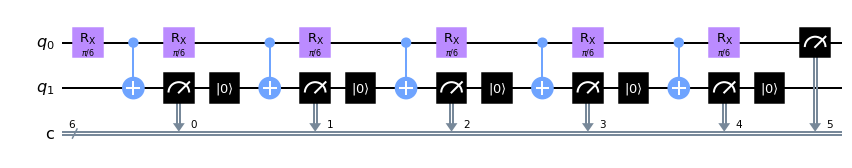

In [2]:
cycles = 6 # Choose the number of times we want to pass our photon through the mystery box. The more, the better. 
theta = np.pi/cycles # The correct reflectivity of our beamsplitter is chosen for the quantum Zeno effect to work.

# Create our quantum circuit 
qr = QuantumRegister(2, 'q')
cr = ClassicalRegister(cycles, 'c')
zt = QuantumCircuit(qr, cr)

# Create a chain of our variable beamsplitters and C-NOT bombs 
for cycle in range(cycles-1):
    zt.append(RXGate(theta), [qr[0]])
    zt.cx(0, 1)
    zt.measure(qr[1],cr[cycle])
    zt.reset(qr[1])

# Add a final beamsplitter
zt.append(RXGate(theta), [qr[0]])

#Measure our photon to predict whether there is a bomb, and measure our bomb qubit to see if it exploded.    
zt.measure(qr[0],cr[cycles-1])
zt.draw(output='mpl')

In [3]:
print(zt.qasm())

OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
creg c[6];
rx(pi/6) q[0];
cx q[0],q[1];
measure q[1] -> c[0];
reset q[1];
rx(pi/6) q[0];
cx q[0],q[1];
measure q[1] -> c[1];
reset q[1];
rx(pi/6) q[0];
cx q[0],q[1];
measure q[1] -> c[2];
reset q[1];
rx(pi/6) q[0];
cx q[0],q[1];
measure q[1] -> c[3];
reset q[1];
rx(pi/6) q[0];
cx q[0],q[1];
measure q[1] -> c[4];
reset q[1];
rx(pi/6) q[0];
measure q[0] -> c[5];



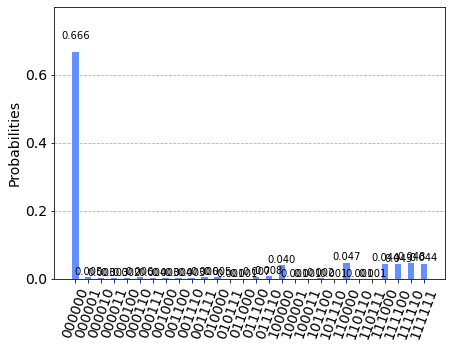

In [4]:
# Running the basic bomb tester circuit

from qiskit.providers.aer import QasmSimulator
simulator = QasmSimulator()

job = simulator.run(zt, shots=1000)
result = job.result()
counts = result.get_counts(zt)

from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [5]:
expected_states = ['000000', '000001', '000010', '000011','000100','000111','001000','001100','001110','001111','010000','011000','011100','011110','011111','100000','110000','111000','111011','111100','111110','111111']  # target states

def get_state_accuracy(counts): # funciton to calculate state accuracy
    expected_counts = 0
    for state in counts.keys():
        if state in expected_states:
            expected_counts = expected_counts + counts[state]
    state_accuracy = expected_counts / shots
    return str(state_accuracy*100)+"%"

In [6]:
counts = execute(zt, backend=Aer.get_backend('qasm_simulator'), shots=shots).result().get_counts() # execution on simulator
state_accuracy = get_state_accuracy(counts)
print(f"state accuracy on the simulator: {state_accuracy}")

state accuracy on the simulator: 99.2%


In [7]:
from qiskit.test.mock import *

backends = [FakeVigo()]

In [8]:
backend1 = FakeVigo()

In [9]:
# compare transpiled circuits for different optimization levels on backend 1

optimization_levels = [0,1,2,3]
print("original circuit")
print(zt)
for optim_level in optimization_levels:
    print(f"optimization level: {optim_level}")
    transpiled_zt = transpile(zt, backend=backend1, optimization_level=optim_level)
    print(transpiled_zt)
    print(transpiled_zt.qasm())

original circuit
     ┌─────────┐     ┌─────────┐          ┌─────────┐          ┌─────────┐     »
q_0: ┤ Rx(π/6) ├──■──┤ Rx(π/6) ├───────■──┤ Rx(π/6) ├───────■──┤ Rx(π/6) ├─────»
     └─────────┘┌─┴─┐└───┬─┬───┘     ┌─┴─┐└───┬─┬───┘     ┌─┴─┐└───┬─┬───┘     »
q_1: ───────────┤ X ├────┤M├─────|0>─┤ X ├────┤M├─────|0>─┤ X ├────┤M├─────|0>─»
                └───┘    └╥┘         └───┘    └╥┘         └───┘    └╥┘         »
c: 6/═════════════════════╩════════════════════╩════════════════════╩══════════»
                          0                    1                    2          »
«          ┌─────────┐          ┌─────────┐     ┌─┐
«q_0: ──■──┤ Rx(π/6) ├───────■──┤ Rx(π/6) ├─────┤M├
«     ┌─┴─┐└───┬─┬───┘     ┌─┴─┐└───┬─┬───┘     └╥┘
«q_1: ┤ X ├────┤M├─────|0>─┤ X ├────┤M├─────|0>──╫─
«     └───┘    └╥┘         └───┘    └╥┘          ║ 
«c: 6/══════════╩════════════════════╩═══════════╩═
«               3                    4           5 
optimization level: 0
global phase: π
              